In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,TensorDataset
from torch_optimizer import RAdam
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.is_available())

cuda
True


In [2]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)


    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))
   

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

   

    return train_data, train_label, test_data, test_label

In [3]:
train_data, train_label, test_data, test_label = read_bci_data()
dataset = TensorDataset(torch.from_numpy(train_data),torch.from_numpy(train_label))
loader_train = DataLoader(dataset,batch_size=256,shuffle=True,num_workers=4)
print(loader_train)
dataset = TensorDataset(torch.from_numpy(test_data),torch.from_numpy(test_label))
loader_test = DataLoader(dataset,batch_size=256,shuffle=False,num_workers=4)


In [4]:
def calculate_accuracy(pred_y, label):
    correct = pred_y.max(dim=1)[1].eq(label).sum().item()
    total = len(label)
    accuracy = (correct / total) * 100
    return accuracy

In [5]:
def plot(relu_train,relu_test,elu_train, elu_test, leakyRelu_train, leakyRelu_test):
    epoch_list = []
    for i in range(len(relu_train)):
        epoch_list.append(i)

    plt.plot(epoch_list, relu_train, label= "relu_train")
    plt.plot(epoch_list, relu_test, label= "relu_test")
    plt.plot(epoch_list, elu_train, label= "elu_train")
    plt.plot(epoch_list, elu_test, label= "elu_test")
    plt.plot(epoch_list, leakyRelu_train, label = "leakyRelu_train")
    plt.plot(epoch_list, leakyRelu_test, label = "leakyRelu_test")
    plt.ylim(50, 100)
    plt.legend(loc = 4)
    plt.show()

In [6]:
class EEGNet(nn.Module):
    def __init__(self,activation=nn.ELU()):
        super(EEGNet,self).__init__()
        self.firstconv=nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(1,51),stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
        )
        self.depthwiseConv=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,4),stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.seperableConv=nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,8),stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify=nn.Linear(736,2)
    def forward(self,inputs):
        output = self.firstconv(inputs)
        output = self.depthwiseConv(output)
        output = self.seperableConv(output)
        output = torch.flatten(output, start_dim=1)
        return self.classify(output)
    
    
    def train_and_test(self, loader_train,loader_test):   
        lr = 1e-2        
        activations={'ReLU':nn.ReLU(),'LeakyReLU':nn.LeakyReLU(),'ELU':nn.ELU()}
        loss = torch.nn.CrossEntropyLoss()
        relu_train = [0]
        relu_test = [0]
        leakyRelu_train = [0]
        leakyRelu_test = [0]
        elu_train = [0]
        elu_test = [0]
        
        Epochs = 300
        for name,act in activations.items():
            print(name)
            if(name == 'LeakyReLU'):
                current_train = leakyRelu_train
                current_test = leakyRelu_test
            elif(name == 'ReLU'):
                current_train = relu_train
                current_test = relu_test
            elif(name == 'ELU'):
                current_train = elu_train
                current_test = elu_test
            else:
                print("error activation")
                
            model=EEGNet(act)
            model.to(device)
            optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
            for epoch in range(1, Epochs+1):
                model.train()
                all_loss = 0
                all_acc = 0
                counter = 0
                for idx,(data,label) in enumerate(loader_train):
                    counter+=1
                    data=data.to(device,dtype=torch.float)
                    label=label.to(device,dtype=torch.long)
                    pred_y = model(data)
                    mono_loss = loss(pred_y, label)
                    all_loss += mono_loss
                    mono_acc = calculate_accuracy(pred_y, label)
                    all_acc += mono_acc
                    optimizer.zero_grad()
                    mono_loss.backward() 
                    optimizer.step()  
                acc = all_acc/counter
                current_train.append(acc)
                if epoch % 10 == 0:
                    print(f"Epoch: {epoch}, Loss: {all_loss/len(loader_train.dataset)}, Accuracy: {acc:.2f}%")
                    
                #test    
                model.eval()
                all_acc = 0
                counter = 0
                for idx,(data,label) in enumerate(loader_test):
                    counter+=1
                    data=data.to(device,dtype=torch.float)
                    label=label.to(device,dtype=torch.long)
                    pred_y = model(data)
                    mono_acc = calculate_accuracy(pred_y, label)
                    all_acc+=mono_acc
                acc = all_acc/counter    
                current_test.append(acc)
                if epoch % 10 == 0:
                    print(f"Test Accuracy: {acc:.2f}%")
                    
                    
            if(name == 'LeakyReLU'):
                leakyRelu_train = current_train
                leakyRelu_test = current_test
            elif(name == 'ReLU'):
                relu_train = current_train
                relu_test = current_test
            elif(name == 'ELU'):
                elu_train = current_train
                elu_test = current_test
            else:
                print("error activation")
                
        return relu_train,relu_test,elu_train, elu_test, leakyRelu_train, leakyRelu_test

    


In [7]:
neural_network = EEGNet()
relu_train,relu_test,elu_train, elu_test, leakyRelu_train, leakyRelu_test = neural_network.train_and_test(loader_train,loader_test)

ReLU
Epoch: 10, Loss: 0.0022041420452296734, Accuracy: 76.15%
Test Accuracy: 72.58%
Epoch: 20, Loss: 0.001784034539014101, Accuracy: 81.15%
Test Accuracy: 74.71%
Epoch: 30, Loss: 0.001389668439514935, Accuracy: 87.03%
Test Accuracy: 80.50%
Epoch: 40, Loss: 0.001196076045744121, Accuracy: 88.84%
Test Accuracy: 82.58%
Epoch: 50, Loss: 0.0010250115301460028, Accuracy: 89.45%
Test Accuracy: 82.13%
Epoch: 60, Loss: 0.0007366387289948761, Accuracy: 94.21%
Test Accuracy: 85.49%
Epoch: 70, Loss: 0.0007374475244432688, Accuracy: 93.94%
Test Accuracy: 85.48%
Epoch: 80, Loss: 0.000556285900529474, Accuracy: 95.85%
Test Accuracy: 86.35%
Epoch: 90, Loss: 0.0006603774963878095, Accuracy: 95.38%
Test Accuracy: 82.12%
Epoch: 100, Loss: 0.0006884967442601919, Accuracy: 93.52%
Test Accuracy: 85.49%
Epoch: 110, Loss: 0.0003909854276571423, Accuracy: 96.63%
Test Accuracy: 87.91%
Epoch: 120, Loss: 0.0004806664655916393, Accuracy: 96.32%
Test Accuracy: 86.82%
Epoch: 130, Loss: 0.000369096698705107, Accuracy

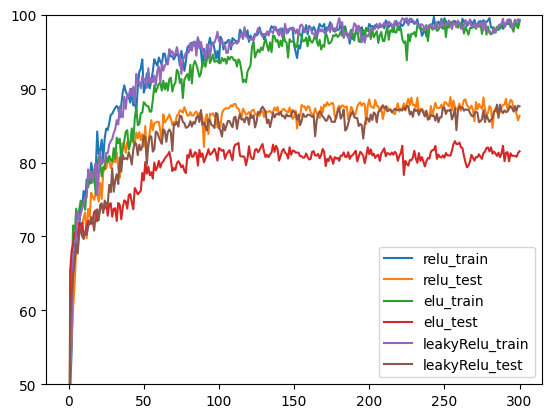

In [8]:
plot(relu_train,relu_test,elu_train, elu_test, leakyRelu_train, leakyRelu_test)

In [13]:
print(f"relu_train max acc：{max(relu_train)}")
print(f"relu_test max acc：{max(relu_test)}")
print(f"elu_train max acc：{max(elu_train)}")
print(f"elu_test max acc：{max(elu_test)}")
print(f"leakyRelu_train max acc：{max(leakyRelu_train)}")
print(f"leakyRelu_test max acc：{max(leakyRelu_test)}")

relu_train max acc：99.6875
relu_test max acc：88.85044642857142
elu_train max acc：99.21875
elu_test max acc：82.890625
leakyRelu_train max acc：99.53125
leakyRelu_test max acc：87.83482142857142
